In [1]:
import os
import numpy as np
import pandas as pd
import librosa, random
from tqdm.notebook import tqdm
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPooling2D, BatchNormalization, 
                          GlobalAveragePooling2D, Dense, Dropout, LSTM, 
                          Bidirectional, TimeDistributed, Flatten)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
import os
import pandas as pd

# =============================
# 1. DATASET LOADING
# =============================
TRAIN_DIR = 'audio/train'
TEST_DIR = 'audio/test'

# Emotion code mapping based on RAVDESS naming convention
EMOTION_MAP = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_emotion(filename):
    """
    Extract emotion label from RAVDESS filename.
    Example: 03-01-06-01-02-01-12.wav -> 'fearful'
    """
    try:
        parts = filename.split('-')
        emotion_id = parts[2]  # third segment indicates emotion
        return EMOTION_MAP.get(emotion_id, 'unknown')
    except Exception:
        return 'unknown'

def create_dataframe(dir):
    audio_paths, labels, emotions = [], [], []
    for label in os.listdir(dir):
        folder = os.path.join(dir, label)
        if not os.path.isdir(folder):
            continue
        for audioname in os.listdir(folder):
            if audioname.endswith(('.wav', '.mp3', '.flac')):
                audio_paths.append(os.path.join(folder, audioname))
                labels.append(label)
                emotions.append(extract_emotion(audioname))
        print(label, "completed")
    return audio_paths, labels, emotions

# Create DataFrames
train = pd.DataFrame()
train['audio'], train['actor'], train['emotion'] = create_dataframe(TRAIN_DIR)

test = pd.DataFrame()
test['audio'], test['actor'], test['emotion'] = create_dataframe(TEST_DIR)

# Optional: preview few samples
print(train.head())


Actor_01 completed
Actor_02 completed
Actor_03 completed
Actor_04 completed
Actor_05 completed
Actor_06 completed
Actor_07 completed
Actor_08 completed
Actor_09 completed
Actor_10 completed
Actor_11 completed
Actor_12 completed
Actor_13 completed
Actor_14 completed
Actor_15 completed
Actor_16 completed
Actor_17 completed
Actor_18 completed
Actor_19 completed
Actor_20 completed
Actor_21 completed
Actor_22 completed
Actor_23 completed
Actor_24 completed
Actor_01 completed
Actor_02 completed
Actor_03 completed
Actor_04 completed
Actor_05 completed
Actor_06 completed
Actor_07 completed
Actor_08 completed
Actor_09 completed
Actor_10 completed
Actor_11 completed
Actor_12 completed
Actor_13 completed
Actor_14 completed
Actor_15 completed
Actor_16 completed
Actor_17 completed
Actor_18 completed
Actor_19 completed
Actor_20 completed
Actor_21 completed
Actor_22 completed
Actor_23 completed
Actor_24 completed
                                           audio     actor  emotion
0  audio/train\Actor

In [16]:

# =============================
# 2. FEATURE EXTRACTION
# =============================
def augment_audio(audio, sr):
    choice = random.choice(['pitch', 'stretch', 'noise', 'none'])
    try:
        if choice == 'pitch':
            audio = librosa.effects.pitch_shift(audio, sr, n_steps=random.uniform(-2, 2))
        elif choice == 'stretch':
            rate = random.uniform(0.8, 1.2)
            audio = librosa.effects.time_stretch(audio, rate)
        elif choice == 'noise':
            noise = np.random.randn(len(audio))
            audio = audio + 0.005 * noise
    except:
        pass
    return audio

def extract_features(file_paths, augment=False, max_len=216):
    features = []
    for path in tqdm(file_paths, desc="Extracting Features"):
        try:
            audio, sr = librosa.load(path, sr=None, duration=3, offset=0.5)
            if augment:
                audio = augment_audio(audio, sr)

            # Core MFCC + Delta + Delta²
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
            delta = librosa.feature.delta(mfcc)
            delta2 = librosa.feature.delta(mfcc, order=2)

            # Chroma and Spectral Contrast
            chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
            spec_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)

            combined = np.vstack((mfcc, delta, delta2, chroma, spec_contrast))

            # Pad or truncate to uniform length
            if combined.shape[1] < max_len:
                pad_width = max_len - combined.shape[1]
                combined = np.pad(combined, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                combined = combined[:, :max_len]

            features.append(combined)
        except Exception as e:
            print(f"⚠️ Skipped {path}: {e}")
            continue

    features = np.array(features)
    features = features.reshape(features.shape[0], combined.shape[0], max_len, 1)
    return features

# ✅ Extract emotion-based features
x_train = extract_features(train['audio'], augment=True)
x_test = extract_features(test['audio'], augment=False)

# Normalize features
x_train = (x_train - np.mean(x_train)) / np.std(x_train)
x_test = (x_test - np.mean(x_test)) / np.std(x_test)

Extracting Features: 100%|██████████| 1440/1440 [01:02<00:00, 22.99it/s]


In [18]:
# =============================
# 3. LABEL ENCODING
# =============================
le = LabelEncoder()
le.fit(train['emotion'])
y_train = to_categorical(le.transform(train['emotion']))
y_test = to_categorical(le.transform(test['emotion']))

print(train.head)



<bound method NDFrame.head of                                               audio     actor    emotion
0     audio/train\Actor_01\03-01-01-01-01-01-01.wav  Actor_01    neutral
1     audio/train\Actor_01\03-01-01-01-01-02-01.wav  Actor_01    neutral
2     audio/train\Actor_01\03-01-01-01-02-01-01.wav  Actor_01    neutral
3     audio/train\Actor_01\03-01-01-01-02-02-01.wav  Actor_01    neutral
4     audio/train\Actor_01\03-01-02-01-01-01-01.wav  Actor_01       calm
...                                             ...       ...        ...
1435  audio/train\Actor_24\03-01-08-01-02-02-24.wav  Actor_24  surprised
1436  audio/train\Actor_24\03-01-08-02-01-01-24.wav  Actor_24  surprised
1437  audio/train\Actor_24\03-01-08-02-01-02-24.wav  Actor_24  surprised
1438  audio/train\Actor_24\03-01-08-02-02-01-24.wav  Actor_24  surprised
1439  audio/train\Actor_24\03-01-08-02-02-02-24.wav  Actor_24  surprised

[1440 rows x 3 columns]>


In [22]:
y_train = to_categorical(le.transform(train['emotion']))
y_test = to_categorical(le.transform(test['emotion']))

num_classes = y_train.shape[1]
print(f"✅ Emotion labels encoded: {list(le.classes_)}")
print(f"Total classes: {num_classes}")

✅ Emotion labels encoded: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Total classes: 8


In [23]:
# =============================
# 4. CNN + BiLSTM MODEL
# =============================
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=x_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    TimeDistributed(Flatten()),

    Bidirectional(LSTM(128, return_sequences=False, dropout=0.3)),

    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])



c:\Users\lokes\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
# =============================
# 5. COMPILE MODEL
# =============================
optimizer = AdamW(learning_rate=0.0008)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 137, 214, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 137, 214, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 68, 107, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 66, 105, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 66, 105, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 33, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 31, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 31, 50, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 15, 6400)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │     6,685,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,125,000 (27.18 MB)

 Trainable params: 7,124,104 (27.18 MB)

 Non-trainable params: 896 (3.50 KB)

In [27]:
# =============================
# 6. TRAINING
# =============================
early_stop = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.4, verbose=1)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=120,
    batch_size=48,
    callbacks=[early_stop, reduce_lr],
    shuffle=True
)

Epoch 1/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.2083 - loss: 2.0273 - val_accuracy: 0.1569 - val_loss: 2.1122 - learning_rate: 8.0000e-04
Epoch 2/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - accuracy: 0.2722 - loss: 1.8810 - val_accuracy: 0.1521 - val_loss: 2.1109 - learning_rate: 8.0000e-04
Epoch 3/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - accuracy: 0.3306 - loss: 1.7473 - val_accuracy: 0.1521 - val_loss: 2.0729 - learning_rate: 8.0000e-04
Epoch 4/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.3521 - loss: 1.6881 - val_accuracy: 0.1979 - val_loss: 2.0315 - learning_rate: 8.0000e-04
Epoch 5/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.3708 - loss: 1.6420 - val_accuracy: 0.1625 - val_loss: 2.2248 - learning_rate: 8.0000e-04
Epoch 6/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.4139 - loss: 1.5245 - val_accuracy: 0.1451 - val_loss: 2.2785 - learning_rate: 8.0000e-04
Epoch 7/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 

In [28]:
# =============================
# 7. SAVE MODEL
# =============================
model_json = model.to_json()
with open("enhanced_emotion.json", "w") as json_file:
    json_file.write(model_json)

model.save("enhanced_emotion.h5")
print("\n✅ High-accuracy Emotion Model trained and saved successfully!")


✅ High-accuracy Emotion Model trained and saved successfully!


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 351ms/step - accuracy: 0.9375 - loss: 0.2816

🎯 Validation Accuracy: 93.75%
📉 Validation Loss: 0.2816
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 343ms/step

🧾 Classification Report:
              precision    recall  f1-score   support

       angry       0.97      0.96      0.97       192
        calm       0.90      0.97      0.94       192
     disgust       0.88      0.96      0.92       192
     fearful       0.95      0.93      0.94       192
       happy       0.96      0.92      0.94       192
     neutral       0.95      0.91      0.93        96
         sad       0.93      0.87      0.90       192
   surprised       0.98      0.97      0.97       192

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.94      0.94      0.94      1440



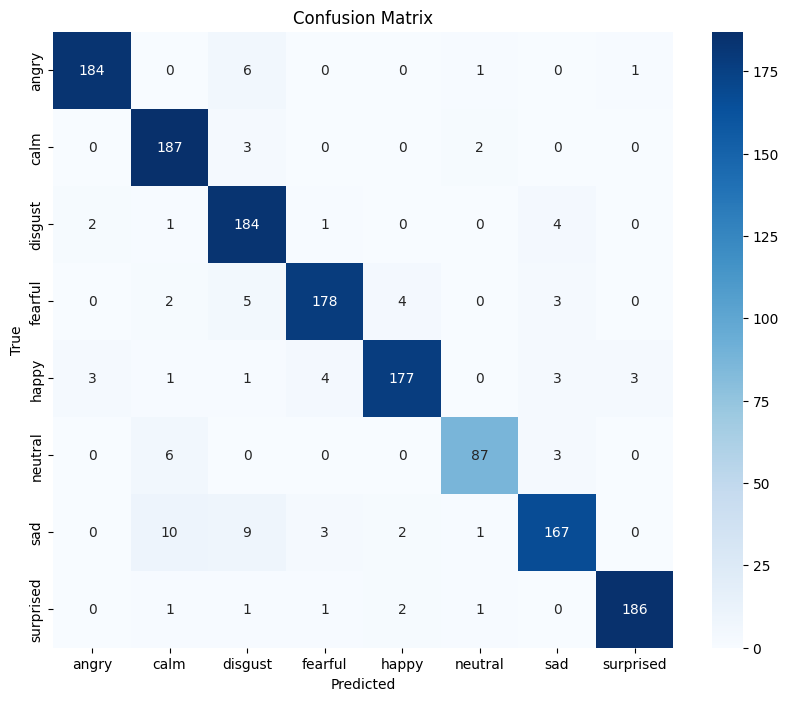

In [29]:
# =============================
# 8. EVALUATION
# =============================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print(f"\n🎯 Validation Accuracy: {test_acc * 100:.2f}%")
print(f"📉 Validation Loss: {test_loss:.4f}")

# Predictions
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Classification report
print("\n🧾 Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

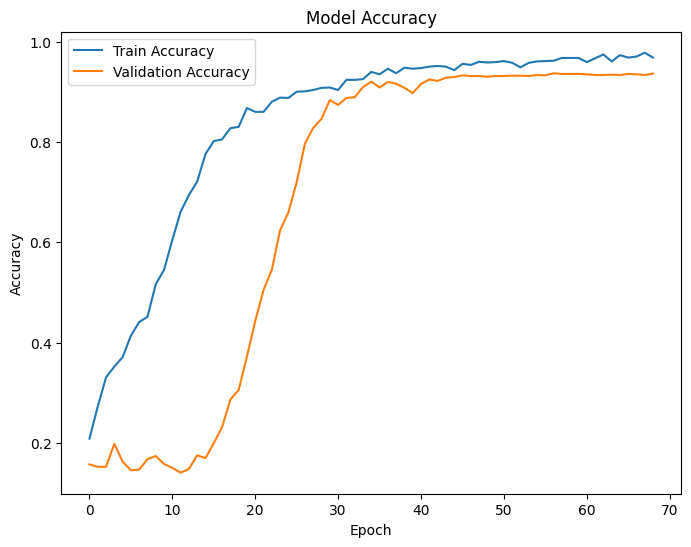

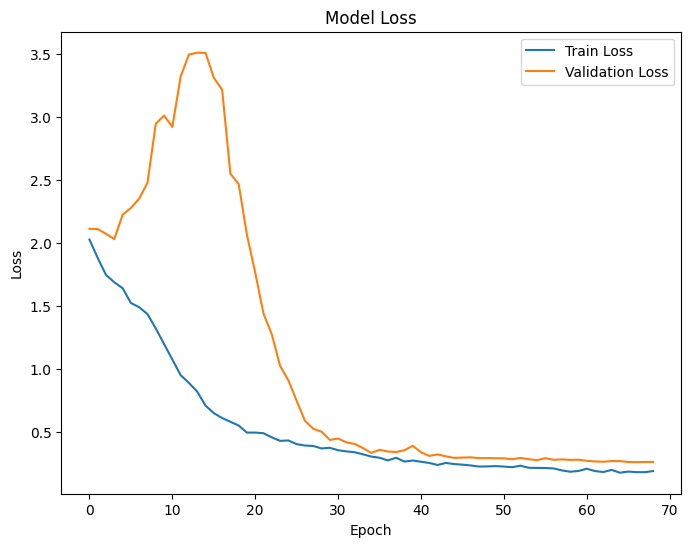

In [30]:
# =============================
# 9. TRAINING CURVES
# =============================
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
import joblib

# ============================
# 3B. SAVE LABEL ENCODER
# ============================
# Save the fitted LabelEncoder
joblib.dump(le, "label_encoder.pkl")
print("✅ Label Encoder saved successfully!")


✅ Label Encoder saved successfully!
